In [35]:
import numpy as np
import tensorflow as tf
import csv
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, InputLayer, UpSampling2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.viewer import ImageViewer
from skimage.io import imsave
import os

%matplotlib inline

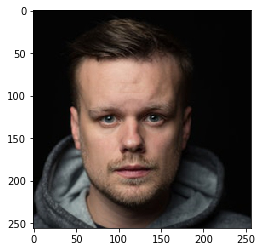

In [36]:
X=[]
i=0
for filename in os.listdir('colornet/testdata/Train'):
    X.append((load_img('colornet/testdata/Train/'+filename)))
#plt.imshow(X[0])
Xt= X
plt.imshow(Xt[0])

10
(10, 256, 256, 3)


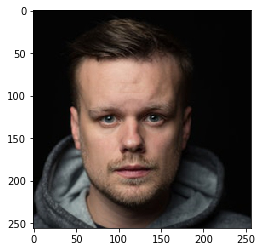

In [37]:
plt.imshow(Xt[0])
print(len(X))
for a in range(int(len(X))):
    X[a]= img_to_array(X[a])
X= np.array(X, dtype= float)
print(X.shape)

In [39]:
print(type(X))
split= int(0.95* len(X))
X_train= X[:split, :,:,:]
X_train= 1.0/255* X

<class 'numpy.ndarray'>


In [40]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [41]:
model.compile(optimizer='rmsprop', loss='mse')

In [43]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [44]:
batch_size = 1
def image_a_b_gen(batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [72]:
#TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size),steps_per_epoch= 1500, epochs=1, verbose=1)

Epoch 1/1
1500/1500 [==============================] - 1704s 1s/step - loss: 0.0034


In [73]:
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 291ms/step
0.000768037571106106


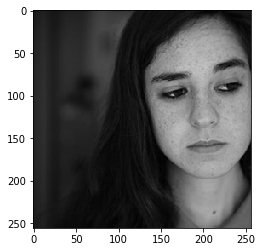

In [74]:
t=[]
for filename in os.listdir('colornet/testdata/Validate'):
    t.append((load_img('colornet/testdata/Validate/'+filename)))
t_raw= t
plt.imshow(t_raw[0])
for i in range(int(len(t))):
    t[i]= img_to_array(t[i])
t= np.array(t, dtype= float)

In [87]:
t1= rgb2lab(1.0/255* t)[:, :, :, 0]
t1= t1.reshape(t1.shape+(1,))

In [88]:
output= model.predict(t1)

In [89]:
output= output*128
cur = np.zeros((256, 256, 3))
cur[:,:,0] = t1[0][:,:,0]
cur[:,:,1:]= output[0]

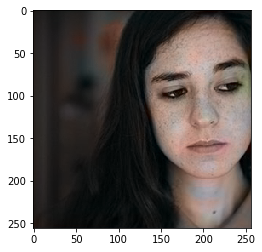

In [90]:
cur= lab2rgb(cur)
plt.imshow(cur)

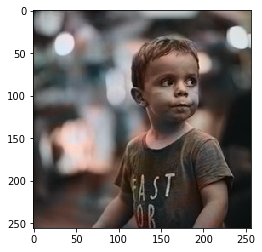

In [94]:

cur[:,:,0]= t1[2][:,:,0]
cur[:,:,1:]= output[2]
cur= lab2rgb(cur)
plt.imshow(cur)

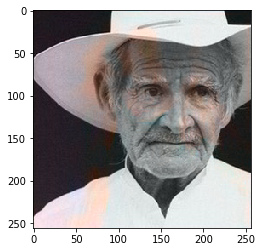

In [95]:
cur[:,:,0]= t1[5][:,:,0]
cur[:,:,1:]= output[3]
cur= lab2rgb(cur)
plt.imshow(cur)

In [98]:
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = t1[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

C:\Users\Lenovo\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
